In [1]:
%matplotlib inline
data = pd.read_pickle("../others/songs_paul.pkl")

In [2]:
data.head()

,artist,song,signal,sample_rate,channel
0,Pink,Are We All We Are,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
1,Pink,Blow Me One Last Kiss,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...",44100,2
2,Pink,Try,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
3,Pink,Just Give Me A Reason,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
4,Pink,True Love,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2


In [3]:
%pylab inline
from utils import wavfilePlayer
from scipy.io import wavfile
index = 410
wavfile.write("sample.wav", data.ix[index]['sample_rate'], data.ix[index]['signal'])
display(wavfilePlayer.wavPlayer("sample.wav"))
print "Song: {}\nArtist: {}".format(data.ix[index]['song'], data.ix[index]['artist'])

Populating the interactive namespace from numpy and matplotlib


Song: Echoes
Artist: Bo Bruce


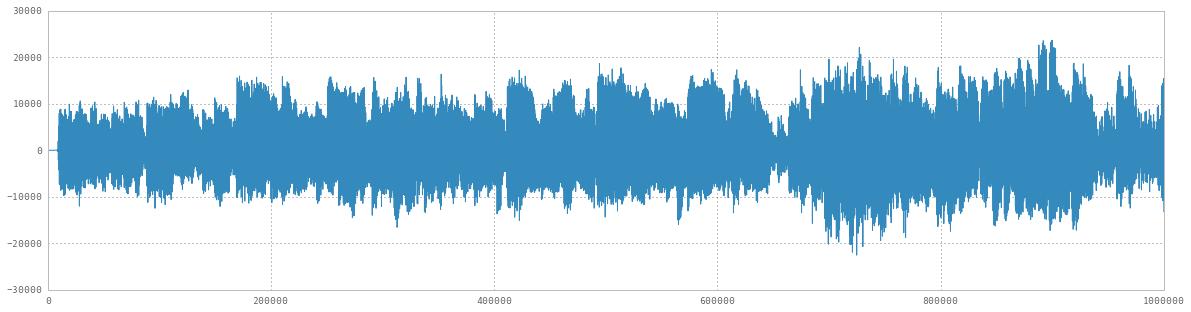

In [4]:
sample = data.ix[index]['signal']
rate = data.ix[index]['sample_rate']
plt.figure(figsize = (20, 5))
plt.plot(sample[:1000000])

In [5]:
def segment_music(df,num_secs):
    segments = []
    for i in df.index:
        song = df.ix[i]['signal']
        num_pts = df.ix[i]['sample_rate']*num_secs
        trimmed = np.trim_zeros(song)
        while np.all(trimmed[:10])==False:
            trimmed = trimmed[5:]
        while np.all(trimmed[-10:])==False:
            trimmed = trimmed[:-5]
        seg_beg = trimmed[:num_pts]
        seg_mid = trimmed[int(trimmed.shape[0]/2)-(num_pts/2):int(trimmed.shape[0]/2)+(num_pts/2)]
        seg_end = trimmed[-num_pts:]
        
        segments.append([seg_beg,seg_mid,seg_end])
    return segments

In [6]:
%%time
segments = segment_music(data, 30)
data['segment_beg'] = map(lambda x: x[0].astype(int), segments)
data['segment_mid'] = map(lambda x: x[1].astype(int), segments)
data['segment_end'] = map(lambda x: x[2].astype(int), segments)

CPU times: user 28.9 s, sys: 26.9 s, total: 55.8 s
Wall time: 3min 17s


In [7]:
data.head()

,artist,song,signal,sample_rate,channel,segment_beg,segment_mid,segment_end
0,Pink,Are We All We Are,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, ...","[809, 903, 417, -201, -177, -333, -995, -1688,...","[16448, 17526, 18439, 17593, 13771, 8368, 3233..."
1,Pink,Blow Me One Last Kiss,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...",44100,2,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...","[10569, 5250, 279, 2198, 5924, 3850, -2975, -9...","[4325, 10096, 14250, 9580, 3494, 3670, 6913, 1..."
2,Pink,Try,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-2, -1, -1, -2, -1, 1, -1, 1, -1, 1, 1, 0, 0,...","[2739, 1973, 1015, 95, -202, -238, -200, -94, ...","[5988, 3302, 3242, 5465, 6914, 6744, 6358, 825..."
3,Pink,Just Give Me A Reason,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-2, -2, -1, 1, 1, -2, -1, -3, -3, -1, -2, -1,...","[-2535, -2845, -3301, -4150, -4906, -5295, -55...","[-9430, -6699, -3657, -452, 2889, 6250, 9652, ..."
4,Pink,True Love,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, ...","[-16230, -12410, -13635, -11647, -9389, -17166...","[18431, 24020, 31532, 32767, 27869, 25101, 263..."


### Features

In [8]:
import librosa as lb

/usr/local/lib/python2.7/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [9]:
def _partition(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) size of the window/frame
    jump: (int) length of distance between windows/frames
    
    Return:
    partitions: (list) list of partitioned windows/frames of length window_length and 
    """
    signal_length = len(signal)
    signal_index = range(signal_length - window_length)
    beg_index = np.array(filter(lambda x: x%jump==0, signal_index))
    end_index = beg_index + window_length
    zipped = zip(beg_index, end_index)
    
    partitions = [signal[i[0]:i[1]] for i in zipped]
    return partitions

Spectral Centroid

In [10]:
#Source: https://en.wikipedia.org/wiki/Spectral_centroid
def _spectral_centroid(signal, rate):
    """
    Params:
    signal: (one-dimensional array)
    rate: (int) sampling rate of the audio signal

    Return:
    spectral_centroid:(float) 
    """
    fft_mag = np.abs(np.fft.rfft(signal))
    freq = np.fft.rfftfreq(len(signal), 1/rate)
    spectral_centroid = np.dot(fft_mag, freq)/sum(fft_mag)
    return spectral_centroid

def spectral_centroid_meanstd(signal, rate, window_length, jump):
    """
    Params:
    signal:(one-dimensional array)
    rate: (int) sampling rate of the audio signal
    window_length: (int) see _partition()
    jump: (int) see_partition()
    
    Return:
    centroid_mean: (float) mean of the spectral centroids of a signal
    centroid_std: (float) standard deviation of the spectral centroids of a signal
    """
    partitions = _partition(signal, window_length, jump)
    centroids = map(lambda x: _spectral_centroid(x, rate), partitions)
    centroid_mean = np.mean(centroids)
    centroid_std = np.std(centroids)
    return centroid_mean, centroid_std

In [11]:
%%time
spectral_centroid_meanstd(sample, rate, rate, rate)

CPU times: user 4.11 s, sys: 724 ms, total: 4.83 s
Wall time: 6.84 s


(2954.918704006654, 1401.9750078042148)

In [12]:
%%time
spec_centroid = lb.feature.spectral_centroid(sample, sr = rate, n_fft=rate, hop_length=rate)
print spec_centroid.mean(), spec_centroid.std()

2855.33390174 1546.22475188
CPU times: user 567 ms, sys: 95.6 ms, total: 662 ms
Wall time: 683 ms


Spectral Roll Off

In [13]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
def _spectral_rolloff(signal):
    """
    Params:
    signal: (one-dimensional array)
    
    Return:
    spectral_rolloff: (float) spectral roll-off of the signal
    """
    fft_mag = np.abs(np.fft.rfft(signal))
    dist85 = 0.85*sum(fft_mag)
    cumsum = np.cumsum(fft_mag)
    lessdist85 = cumsum<dist85
    spectral_rolloff = np.sum(lessdist85)
    return spectral_rolloff
def spectral_rolloff_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    roll_off_mean: (float) mean of the spectral roll-offs of the windows generated from the signal
    roll_off_std: (float) standard deviation of the spectral roll-offs of the windows generated from the signal
    """
    partitions = _partition(signal, window_length, jump)
    roll_offs = map(lambda x: _spectral_rolloff(x), partitions)
    roll_off_mean = np.mean(roll_offs)
    roll_off_std = np.std(roll_offs)
    return roll_off_mean, roll_off_std

In [14]:
%%time
spectral_rolloff_meanstd(sample, rate, rate)

CPU times: user 3.7 s, sys: 84.8 ms, total: 3.78 s
Wall time: 3.83 s


(7240.782608695652, 4027.3020179824321)

In [15]:
%%time
roll_off = lb.feature.spectral_rolloff(sample, sr = rate, n_fft = rate, hop_length=rate)
print roll_off.mean(), roll_off.std()

7078.96969697 4165.13089071
CPU times: user 523 ms, sys: 56.9 ms, total: 580 ms
Wall time: 586 ms


Spectral Flow/Spectral Flux

In [16]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
#spectral flow and spectral flux are the same thing.
def spectral_flow_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    flow_mean: (float) mean of the spectral flow of the signal
    flow_std: (float) standard deviation of the spectral flow of the signal
    """
    partitions = _partition(signal, window_length, jump)
    normalized_partitions = map(lambda x: x.astype(int)/np.linalg.norm(x.astype(int)), partitions)
    Nt = np.array(normalized_partitions[1:])
    Nt1 = np.array(normalized_partitions[:len(normalized_partitions)-1])
    Ft = np.sum((Nt - Nt1)**2, axis = 1)
    flow_mean = Ft.mean()
    flow_std = Ft.std()
    return flow_mean, flow_std
    

In [17]:
%%time
spectral_flow_meanstd(sample, rate, rate)

CPU times: user 3.34 s, sys: 189 ms, total: 3.53 s
Wall time: 3.55 s


(2.0071135900237427, 0.24234006696407315)

Zero-Crossing Rate Mean

In [18]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
def zero_crossing_rate_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    zero_crossing_rate_mean: (float) mean of the zero crossing rates of the windows
    zero_crossing_rate_std: (float) standard deviation of the zero crossing rates of the windows
    """
    
    partitions = np.array(_partition(signal, window_length, jump))
    m,n = partitions.shape
    sign, sign1 = partitions[:, 1:]>0, partitions[:, :n-1]>0
    zero_crossing_rate  = (np.sum(np.abs(sign - sign1), axis = 1))/n
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_std = zero_crossing_rate.std()
    return zero_crossing_rate_mean, zero_crossing_rate_std

In [19]:
%%time
zero_crossing_rate_meanstd(sample, rate, rate)

CPU times: user 3.46 s, sys: 102 ms, total: 3.56 s
Wall time: 3.62 s


(0.034392388839593807, 0.018680015919611881)

In [20]:
%%time
zero_crossing_rate = lb.feature.zero_crossing_rate(sample, rate, rate)
print zero_crossing_rate.mean(), zero_crossing_rate.std()

0.0349333961579 0.0196877716621
CPU times: user 185 ms, sys: 66.3 ms, total: 251 ms
Wall time: 254 ms


Low Energy 

In [21]:
def rms_energy(signal):
    """
    Params:
    signal: (one-dimensional array)
    
    Return:
    rmsenergy: (float) root mean square energy of the signal
    """
    
    rmsenergy = np.sqrt(np.mean(signal**2))
    return rmsenergy

In [22]:
#Source(definition of RMS energy): http://blog.prosig.com/2015/01/06/rms-from-time-history-and-fft-spectrum/
#SOurce(definition of low energy feature): 
def lowenergy_feature(signal, aw_windowlength, tw_windowlength, jump):
    """
    Params:
    signal: (one-dimensional array)
    aw_windowlength: (int) window length of the analysis windows
    tw_windowlength: (int) window length of the texture windows
    jump: (int) see _partition()
    
    Return:
    lowenergy_percentage: (float) between 0-1,the percentage of analysis windows that have less
                            RMS energy than the average RMS energy across the texture window
    """
    if tw_windowlength< aw_windowlength:
        raise ValueError
    signal = signal.astype(int)
    partitions_analysis = _partition(signal, aw_windowlength, jump)
    partitions_texture = _partition(signal, tw_windowlength, jump)
    rmsenergy_analysis = map(lambda x: rms_energy(x), partitions_analysis)
    rmsenergy_texture = map(lambda x: rms_energy(x), partitions_texture)
    ave_rmsenergy_texture = np.mean(rmsenergy_texture)
    lowenergy_percentage = np.mean(rmsenergy_analysis<ave_rmsenergy_texture)
    return lowenergy_percentage

In [31]:
%%time
lowenergy_feature(sample, rate*5, rate*10, rate)

CPU times: user 3.66 s, sys: 612 ms, total: 4.28 s
Wall time: 4.63 s


0.33628318584070799

### Cythonize the Functions

In [24]:
#the cython functions are stored in cython_func module
from utils import cython_func as cf

In [27]:
%%time
rate = 44100
window = 15*rate #15 sec
jump = rate #1 sec
#spectral_centroid_beg = data.segment_beg.map(lambda x: cf.spectral_centroid_meanstdc(x, rate, window, jump))
#spectral_centroid_mid = data.segment_mid.map(lambda x: cf.spectral_centroid_meanstdc(x, rate, window, jump))
spectral_centroid_end = data.segment_end.map(lambda x: cf.spectral_centroid_meanstdc(x, rate, window, jump))

CPU times: user 10min 2s, sys: 40.4 s, total: 10min 42s
Wall time: 11min 11s


In [32]:
%%time
spectral_rolloff_beg = data.segment_beg.map(lambda x: cf.spectral_rolloff_meanstdc(x, window, jump))
#spectral_rolloff_mid = data.segment_mid.map(lambda x: cf.spectral_rolloff_meanstdc(x, window, jump))
#spectral_rolloff_end = data.segment_end.map(lambda x: cf.spectral_rolloff_meanstdc(x, window, jump))

CPU times: user 10min 35s, sys: 48.2 s, total: 11min 23s
Wall time: 11min 59s


In [48]:
%%time 
c = data.segment_beg.map(lambda x: np.mean(lb.feature.spectral_centroid(x, sr = rate, n_fft=rate, hop_length=rate)))

CPU times: user 30.8 s, sys: 4.78 s, total: 35.5 s
Wall time: 39.8 s


# Pitch Content Features

In [111]:
import scipy.signal as ss

In [112]:
def decompose(signal):
    B_low,A_low = ss.cheby1(N = 5, rp = 1, Wn = 1000/22050, btype='lowpass')
    B_hi,A_hi = ss.cheby1(N = 5, rp = 1, Wn = 1000/22050, btype='highpass')
    low_pass = ss.lfilter(B_low,A_low,signal)
    high_pass = ss.lfilter(B_hi,A_hi,signal)
    return low_pass, high_pass

def lpfilter(signal,alpha=0.99):
    y = range(len(signal))
    y[0] = 0
    for i in xrange(1,len(signal)):
        y[i] = ((1-alpha) * signal[i]) + (alpha * y[i-1])
    return np.array(y)

def acf(signal):
    n = len(signal)
    array = np.array([np.dot(signal[:n-i], signal[i:])/float(n) for i in xrange(n)]) 
    return array

def half_wave_rectify(signal):
    hwr = signal.copy()
    hwr[hwr<0]=0
    return hwr

def sacf(signal):
    low,hi = decompose(signal)
    env_low = acf(lpfilter(half_wave_rectify(low)))
    env_hi = acf(lpfilter(half_wave_rectify(hi)))
    env_sum = env_low + env_hi
    return env_sum

In [27]:
sample = data.segment_beg[100]
partitions = cf._partitionc(sample, 44100/1000*46, 44100/1000*46) #window length is 46 ms, jump is 46 ms

In [272]:
%%time
sacfs = map(sacf, partitions)

CPU times: user 5.95 s, sys: 6.28 ms, total: 5.96 s
Wall time: 5.96 s


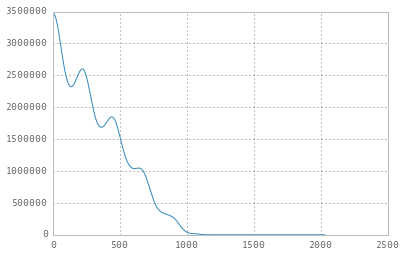

In [282]:
plt.plot(sacfs[5])

In [274]:
def peak(array):
    z=np.diff(array)
    ind = []
    for i in xrange(len(z)-1):
        if z[i+1] < 0 and z[i] > 0:
            ind.append((array[i+1],i))
    return sorted(ind)[-3:]

In [275]:
%%time
peaks = map(peak, sacfs)

CPU times: user 605 ms, sys: 10.5 ms, total: 615 ms
Wall time: 621 ms


In [263]:
import itertools as it
peaks_flat = list(it.chain.from_iterable(peaks))

In [264]:
unfolded = [(int(i[0]), int(12*np.log2(i[1]/440))+69)for i in peaks_flat]
folded = [(i[0], i[1]%12) for i in unfolded]

In [265]:
unfoldedsort = sorted(unfolded, key  = lambda x: x[1])
foldedsort = sorted(folded, key = lambda x: x[1])

In [290]:
accum_unfolded = []
for key,group in it.groupby(unfoldedsort, lambda x: x[1]):
    accum_unfolded.append((key, sum([i[0] for i in group])))

<Container object of 3 artists>

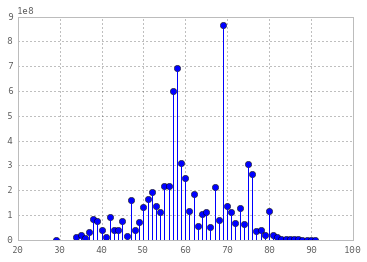

In [267]:
plt.stem(np.array(accum_unfolded)[:,0], np.array(accum_unfolded)[:,1])

In [268]:
accum_folded = []
for key,group in it.groupby(foldedsort, lambda x: x[1]):
    accum_folded.append((key, sum([i[0] for i in group])))

<Container object of 3 artists>

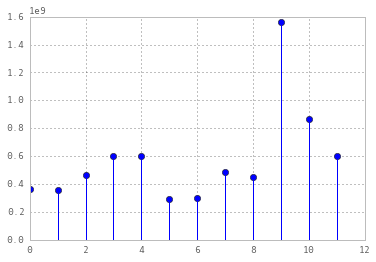

In [269]:
plt.stem(np.array(accum_folded)[:,0], np.array(accum_folded)[:,1])